# Analyzing Effects of Model Ensembling
By: Prajwal Brijesh Ainapur

This notebook covers the effects of model ensembling on dataset-1

In [1]:
#Importing Libraries
from collections import Counter
from imblearn.combine import SMOTEENN
from pycaret import classification, clustering
from pycaret.classification import *
from sklearn.model_selection import StratifiedShuffleSplit, train_test_split
from sklearn.metrics import confusion_matrix, recall_score
from sklearn import metrics

from sklearn.feature_selection import SelectFromModel
from sklearn.linear_model import LogisticRegression
from sklearn import preprocessing

import seaborn as sns
import pycaret
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt


import warnings
warnings.filterwarnings('ignore')

Using TensorFlow backend.


In [2]:
df = pd.read_csv('/home/prajwal_brijesh_ainapur/upgradSubmissions/MS_PGM/bank-additional/bank-additional-full.csv')

In [3]:
df.head()

,age,job,marital,education,default,housing,loan,contact,month,day_of_week,...,campaign,pdays,previous,poutcome,emp.var.rate,cons.price.idx,cons.conf.idx,euribor3m,nr.employed,y
0,56,housemaid,married,basic.4y,no,no,no,telephone,may,mon,...,1,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,no
1,57,services,married,high.school,unknown,no,no,telephone,may,mon,...,1,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,no
2,37,services,married,high.school,no,yes,no,telephone,may,mon,...,1,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,no
3,40,admin.,married,basic.6y,no,no,no,telephone,may,mon,...,1,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,no
4,56,services,married,high.school,no,no,yes,telephone,may,mon,...,1,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,no


As per the dataset description, the duration column is added only after the call is made with the customer and thus, this information is not available well in advance. Thus we proceed to remove this column in order to create a realistic prediction model.

In [4]:
df = df.drop(columns = ['duration'], axis = 1)
df.shape

(41188, 20)

In [5]:
print(df.shape)
df = df.drop_duplicates()
print(df.shape)

(41188, 20)
(39404, 20)


In [11]:
def getSampled(x, y, tmp):
    
    _x, _y = tmp().fit_resample(x, y)
    counter= Counter(_y)
    print(counter)
    
    return _x, _y

def trainPredict(modelName, xTrain, yTrain):

    df_tmp = pd.concat([xTrain, yTrain], axis = 1)
    classification_setup = classification.setup(data= df_tmp, target='y', fix_imbalance = False)
    model = create_model(modelName, learning_rate = 0.3)
    return model


def plotModel(fittedModel, xTest, yTest, title = None):    
    
    model_final = finalize_model(fittedModel)

    y_pred = predict_model(model_final, data = xTest)

    cmat = confusion_matrix(yTest, y_pred.Label)
    print(cmat)
    trec = recall_score(yTest, y_pred.Label)
    print(trec)
    
    fpr, tpr, thresholds = metrics.roc_curve(yTest, y_pred.Label)
    roc_auc = (metrics.auc(fpr, tpr))

    plt.title('Receiver Operating Characteristic' + str(title))
    plt.plot(fpr, tpr, 'b', label = 'AUC = %0.2f' % roc_auc)
    plt.legend(loc = 'lower right')
    plt.plot([0, 1], [0, 1],'r--')
    plt.xlim([0, 1])
    plt.ylim([0, 1])
    plt.ylabel('True Positive Rate')
    plt.xlabel('False Positive Rate')
    plt.show()

In [12]:
X = df.drop(columns = ['y'], axis = 1)
y = df['y']

Xd = pd.get_dummies(X, drop_first = True)
Xd.shape

(39404, 52)

In [13]:
y = y.replace('no', 0)
y = y.replace('yes', 1)
counter = Counter(y)
print(counter)

Counter({0: 34806, 1: 4598})


In [23]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(Xd, y, stratify = y, test_size = 0.25)

In [24]:
X_trains, y_trains = getSampled(X_train, y_train, SMOTEENN)

Counter({1: 25021, 0: 15693})


In [25]:
modelU = trainPredict('lightgbm', X_train, y_train)

,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC
0,0.8937,0.7706,0.2863,0.5897,0.3855,0.3348,0.3612
1,0.8937,0.7656,0.3154,0.5802,0.4086,0.3557,0.3758
2,0.8927,0.7647,0.2905,0.5785,0.3867,0.3350,0.3589
3,0.8830,0.7525,0.2355,0.5000,0.3202,0.2652,0.2878
4,0.8937,0.7718,0.2851,0.5948,0.3855,0.3351,0.3624
5,0.8985,0.7921,0.3430,0.6194,0.4415,0.3907,0.4114
6,0.8956,0.7834,0.3058,0.6066,0.4066,0.3561,0.3813
7,0.8893,0.7414,0.2365,0.5588,0.3324,0.2826,0.3140
8,0.8893,0.7710,0.2988,0.5455,0.3861,0.3309,0.3490
9,0.8878,0.7661,0.2697,0.5372,0.3591,0.3050,0.3268


[[8489  213]
 [ 825  324]]
0.2819843342036554


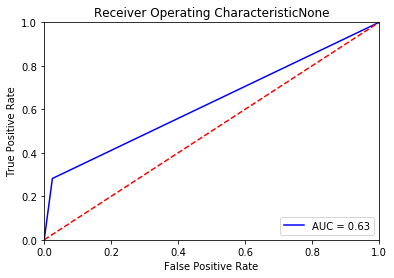

In [26]:
plotModel(modelU, X_test, y_test)

Iteration 1: Plain Lgbms with direct data

Recall: 0.282
AUC: 0.63

### 2. SMOTEENN sample data + plaing LGBMS

In [28]:
modelS = trainPredict('lightgbm', X_trains, y_trains)

,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC
0,0.9544,0.9845,0.9521,0.9732,0.9625,0.9043,0.9047
1,0.9446,0.9801,0.9372,0.9716,0.9541,0.8842,0.8851
2,0.9537,0.9868,0.9492,0.9748,0.9618,0.9030,0.9035
3,0.9453,0.9773,0.9361,0.9739,0.9546,0.8858,0.8869
4,0.9505,0.9827,0.9435,0.9752,0.9591,0.8966,0.8974
5,0.9526,0.9822,0.9452,0.9770,0.9608,0.9010,0.9018
6,0.9540,0.9845,0.9515,0.9731,0.9622,0.9036,0.9040
7,0.9512,0.9817,0.9503,0.9697,0.9599,0.8977,0.8980
8,0.9432,0.9834,0.9446,0.9622,0.9533,0.8807,0.8809
9,0.9463,0.9788,0.9412,0.9706,0.9556,0.8876,0.8883


[[7567 1135]
 [ 437  712]]
0.6196692776327241


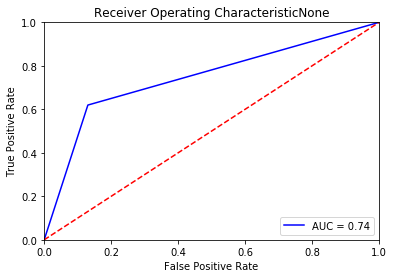

In [29]:
plotModel(modelS, X_test, y_test)

Iteration 2: Sampling using SMOTEENN and LGBMS with no hyperparameter tuning

Recall: 0.62
AUC: 0.74

### 3. L1+Saga+SMOTEENN+LightGBM

In [290]:
from sklearn import preprocessing

# scaler = preprocessing.StandardScaler()1
# scaler = preprocessing.MinMaxScaler()

cols = X_trains.columns

# Xds = scaler.fit_transform(Xd)
# Xds = pd.DataFrame(Xds, columns = Xd.columns)
Xds = Xd

X_train_, X_testss, y_train_, y_testss = train_test_split(Xds, y, stratify = y, test_size = 0.25)

X_trainss, y_trainss = getSampled(X_train_, y_train_, SMOTEENN)

Counter({1: 25043, 0: 15567})


In [291]:
Xds.head()

,age,campaign,pdays,previous,emp.var.rate,cons.price.idx,cons.conf.idx,euribor3m,nr.employed,job_blue-collar,...,month_may,month_nov,month_oct,month_sep,day_of_week_mon,day_of_week_thu,day_of_week_tue,day_of_week_wed,poutcome_nonexistent,poutcome_success
0,56,1,999,0,1.1,93.994,-36.4,4.857,5191.0,0,...,1,0,0,0,1,0,0,0,1,0
1,57,1,999,0,1.1,93.994,-36.4,4.857,5191.0,0,...,1,0,0,0,1,0,0,0,1,0
2,37,1,999,0,1.1,93.994,-36.4,4.857,5191.0,0,...,1,0,0,0,1,0,0,0,1,0
3,40,1,999,0,1.1,93.994,-36.4,4.857,5191.0,0,...,1,0,0,0,1,0,0,0,1,0
4,56,1,999,0,1.1,93.994,-36.4,4.857,5191.0,0,...,1,0,0,0,1,0,0,0,1,0


In [375]:
sel_ = SelectFromModel(LogisticRegression(C=0.05, penalty='l1', solver = 'saga'))
sel_.fit(X_trainss, y_trainss)

SelectFromModel(estimator=LogisticRegression(C=0.05, class_weight=None,
                                             dual=False, fit_intercept=True,
                                             intercept_scaling=1, l1_ratio=None,
                                             max_iter=100, multi_class='auto',
                                             n_jobs=None, penalty='l1',
                                             random_state=None, solver='saga',
                                             tol=0.0001, verbose=0,
                                             warm_start=False),
                max_features=None, norm_order=1, prefit=False, threshold=None)

In [376]:
selected_feat = X_trainss.columns[(sel_.get_support())]

print('total features: {}'.format((X_trainss.shape[1])))
print('selected features: {}'.format(len(selected_feat)))
print('features with coefficients shrank to zero: {}'.format(
      np.sum(sel_.estimator_.coef_ >= 0.001)))

total features: 52
selected features: 49
features with coefficients shrank to zero: 7


In [381]:
removed_feats = X_trainss.columns[(sel_.estimator_.coef_ >= 0.00005).ravel().tolist()]

removed_feats

Index(['age', 'cons.price.idx', 'job_retired', 'job_student', 'marital_single',
       'month_aug', 'month_dec', 'month_jul', 'month_mar', 'month_oct',
       'month_sep', 'poutcome_success'],
      dtype='object')

In [382]:
X_train1 = X_trainss[removed_feats]
X_train1.head()

,age,cons.price.idx,job_retired,job_student,marital_single,month_aug,month_dec,month_jul,month_mar,month_oct,month_sep,poutcome_success
0,31,93.444,0,0,0,1,0,0,0,0,0,0
1,45,93.994,0,0,0,0,0,0,0,0,0,0
2,55,92.893,0,0,0,0,0,0,0,0,0,0
3,47,93.075,0,0,1,0,0,0,0,0,0,0
4,51,93.200,0,0,0,0,0,0,0,0,0,0


In [383]:
modelL = trainPredict('lightgbm', X_train1, y_trainss)

,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC
0,0.7974,0.8895,0.7872,0.8718,0.8273,0.5838,0.5882
1,0.7897,0.8899,0.7781,0.8671,0.8202,0.5686,0.5735
2,0.7928,0.8852,0.7855,0.8660,0.8238,0.5739,0.5779
3,0.8020,0.8992,0.7952,0.8723,0.8320,0.5921,0.5959
4,0.7897,0.8846,0.7684,0.8752,0.8183,0.5710,0.5779
5,0.7921,0.8879,0.7741,0.8744,0.8212,0.5751,0.5812
6,0.7882,0.8840,0.7643,0.8763,0.8165,0.5688,0.5763
7,0.8033,0.8968,0.8003,0.8703,0.8339,0.5939,0.5970
8,0.8008,0.8896,0.7929,0.8726,0.8308,0.5901,0.5941
9,0.7843,0.8785,0.7735,0.8626,0.8156,0.5576,0.5624


[[6185 2516]
 [ 378  772]]
0.671304347826087


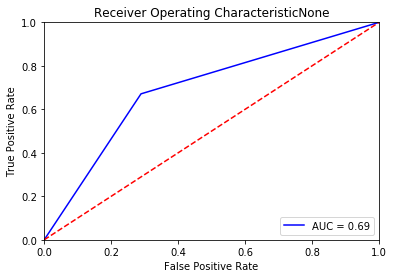

In [384]:
plotModel(modelL, X_testss, y_testss)

### 4. SMOTEENN + Manual Feature Selection using EDA

In [430]:
selected_feat = ['default_yes', 'contact_telephone', 'poutcome_nonexistent', 'poutcome_success', 
                'job_student', 'job_retired', 'marital_unknown', 'education_basic.9y', 'education_basic.6y', 
                'cons.price.idx', 'campaign']

In [431]:
Xd.columns

Index(['age', 'campaign', 'pdays', 'previous', 'emp.var.rate',
       'cons.price.idx', 'cons.conf.idx', 'euribor3m', 'nr.employed',
       'job_blue-collar', 'job_entrepreneur', 'job_housemaid',
       'job_management', 'job_retired', 'job_self-employed', 'job_services',
       'job_student', 'job_technician', 'job_unemployed', 'job_unknown',
       'marital_married', 'marital_single', 'marital_unknown',
       'education_basic.6y', 'education_basic.9y', 'education_high.school',
       'education_illiterate', 'education_professional.course',
       'education_university.degree', 'education_unknown', 'default_unknown',
       'default_yes', 'housing_unknown', 'housing_yes', 'loan_unknown',
       'loan_yes', 'contact_telephone', 'month_aug', 'month_dec', 'month_jul',
       'month_jun', 'month_mar', 'month_may', 'month_nov', 'month_oct',
       'month_sep', 'day_of_week_mon', 'day_of_week_thu', 'day_of_week_tue',
       'day_of_week_wed', 'poutcome_nonexistent', 'poutcome_success'],
  

In [432]:
X_train1 = X_trainss[selected_feat]
X_train1.head()

,default_yes,contact_telephone,poutcome_nonexistent,poutcome_success,job_student,job_retired,marital_unknown,education_basic.9y,education_basic.6y,cons.price.idx,campaign
0,0,0,1,0,0,0,0,0,0,93.444,2
1,0,1,1,0,0,0,0,0,0,93.994,1
2,0,0,1,0,0,0,0,1,0,92.893,1
3,0,0,1,0,0,0,0,1,0,93.075,2
4,0,0,0,0,0,0,0,0,0,93.200,2


In [433]:
modelL = trainPredict('lightgbm', X_train1, y_trainss)

,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC
0,0.7953,0.8858,0.8072,0.8529,0.8294,0.5740,0.5753
1,0.7960,0.8841,0.8163,0.8472,0.8315,0.5733,0.5739
2,0.8076,0.8955,0.8209,0.8606,0.8403,0.5987,0.5998
3,0.8104,0.8963,0.8203,0.8652,0.8422,0.6052,0.6066
4,0.7963,0.8870,0.8089,0.8532,0.8305,0.5760,0.5772
5,0.8051,0.8906,0.8243,0.8545,0.8391,0.5922,0.5929
6,0.7889,0.8820,0.8076,0.8433,0.8251,0.5592,0.5600
7,0.7963,0.8889,0.8100,0.8523,0.8307,0.5754,0.5766
8,0.8030,0.8919,0.8146,0.8587,0.8361,0.5896,0.5909
9,0.8015,0.8909,0.8140,0.8571,0.8350,0.5865,0.5877


[[5972 2729]
 [ 332  818]]
0.711304347826087


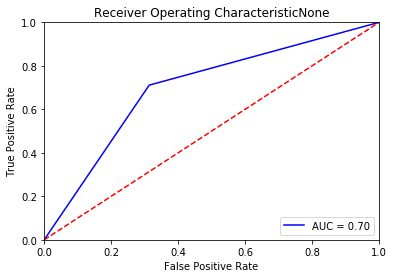

In [434]:
plotModel(modelL, X_testss, y_testss)

### 5. SMOTEENN + Manual Feature Selection + top5 Pycaret

In [443]:
top5 = compare_models(n_select = 5, blacklist = ['catboost'], sort = 'AUC') 

,Model,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC,TT (Sec)
0,Extreme Gradient Boosting,0.8009,0.8898,0.8152,0.8551,0.8347,0.5847,0.5858,1.9799
1,Light Gradient Boosting Machine,0.7999,0.8890,0.8143,0.8544,0.8338,0.5827,0.5838,0.3077
2,Random Forest Classifier,0.7976,0.8865,0.8085,0.8554,0.8313,0.5789,0.5804,0.1163
3,Extra Trees Classifier,0.7969,0.8859,0.8060,0.8563,0.8304,0.5780,0.5797,0.4520
4,Decision Tree Classifier,0.7981,0.8854,0.8075,0.8569,0.8314,0.5803,0.5819,0.0248
5,Gradient Boosting Classifier,0.7939,0.8826,0.8097,0.8490,0.8289,0.5700,0.5711,1.2512
6,Ada Boost Classifier,0.7820,0.8710,0.8287,0.8198,0.8242,0.5373,0.5374,0.4847
7,K Neighbors Classifier,0.7619,0.8456,0.7811,0.8250,0.8015,0.5041,0.5068,0.4188
8,Linear Discriminant Analysis,0.7480,0.8148,0.8594,0.7623,0.8079,0.4455,0.4523,0.0800
9,Logistic Regression,0.7496,0.8029,0.8501,0.7685,0.8072,0.4527,0.4575,0.3881


[[5969 2732]
 [ 332  818]]
0.711304347826087


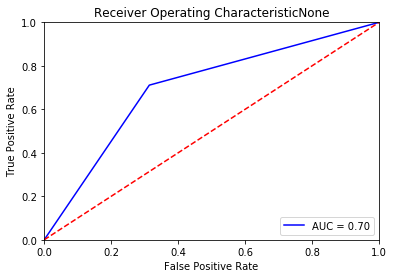

In [444]:
tec = None
plotModel(top5[0], X_testss, y_testss)

[[5942 2759]
 [ 324  826]]
0.7182608695652174


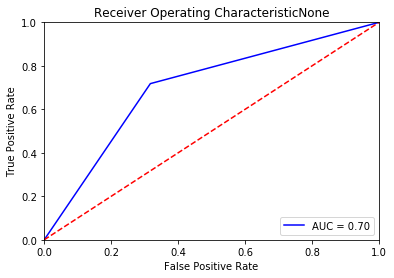

In [445]:
tec = None
plotModel(top5[1], X_testss, y_testss)

[[6088 2613]
 [ 346  804]]
0.6991304347826087


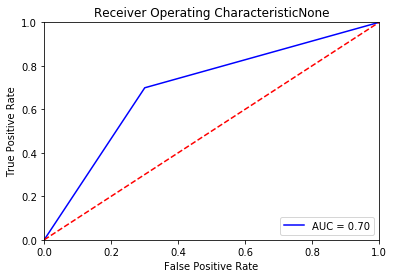

In [446]:
tec = None
plotModel(top5[2], X_testss, y_testss)

[[6145 2556]
 [ 352  798]]
0.6939130434782609


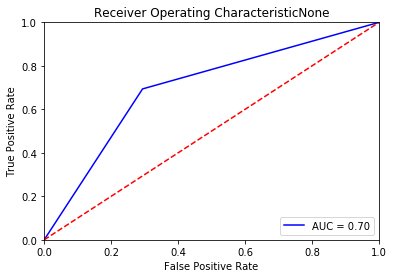

In [447]:
tec = None
plotModel(top5[3], X_testss, y_testss)

[[6139 2562]
 [ 352  798]]
0.6939130434782609


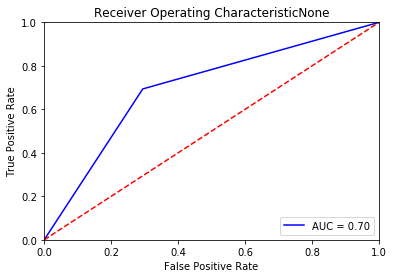

In [448]:
tec = None
plotModel(top5[4], X_testss, y_testss)

### 6. Stacked models

In [452]:
stacker = stack_models(estimator_list = [top5[0], top5[2], top5[3], top5[4]], meta_model = top5[1])

,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC
0,0.7992,0.8889,0.8112,0.8556,0.8328,0.5818,0.5831
1,0.7999,0.8885,0.8083,0.8588,0.8328,0.5841,0.5858
2,0.8097,0.8987,0.8169,0.8668,0.8411,0.6045,0.6061
3,0.8125,0.9008,0.8272,0.8631,0.8447,0.6084,0.6093
4,0.7946,0.8937,0.7912,0.8642,0.8261,0.5764,0.5798
5,0.8058,0.8921,0.8197,0.8589,0.8389,0.5950,0.5960
6,0.7892,0.8830,0.8019,0.8479,0.8243,0.5615,0.5629
7,0.8044,0.8921,0.8060,0.8674,0.8356,0.5949,0.5973
8,0.8065,0.8964,0.8163,0.8626,0.8388,0.5972,0.5986
9,0.8061,0.8983,0.8209,0.8586,0.8393,0.5953,0.5962


[[6077 2624]
 [ 333  817]]
0.7104347826086956


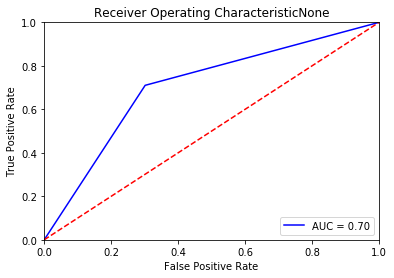

In [453]:
tec = None
plotModel(stacker, X_testss, y_testss)
#lgbm

[[5950 2751]
 [ 336  814]]
0.7078260869565217


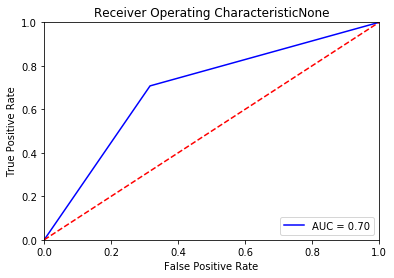

In [450]:
tec = None
plotModel(stacker, X_testss, y_testss)
#xgb

In [461]:
blender_specific = blend_models(estimator_list = [top5[0], top5[1]], method = 'soft')

,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC
0,0.7939,0.8844,0.8066,0.8513,0.8284,0.5709,0.5722
1,0.7977,0.8843,0.8169,0.8493,0.8328,0.5771,0.5779
2,0.8087,0.8976,0.8197,0.8631,0.8408,0.6014,0.6026
3,0.8111,0.8965,0.8232,0.8641,0.8431,0.6062,0.6073
4,0.7985,0.8893,0.8095,0.8559,0.8320,0.5806,0.5820
5,0.8048,0.8909,0.8237,0.8544,0.8388,0.5916,0.5922
6,0.7899,0.8817,0.8122,0.8415,0.8266,0.5604,0.5610
7,0.7966,0.8882,0.8083,0.8541,0.8306,0.5767,0.5781
8,0.8040,0.8938,0.8169,0.8585,0.8372,0.5914,0.5926
9,0.8023,0.8906,0.8135,0.8585,0.8354,0.5883,0.5896


[[5927 2774]
 [ 324  826]]
0.7182608695652174


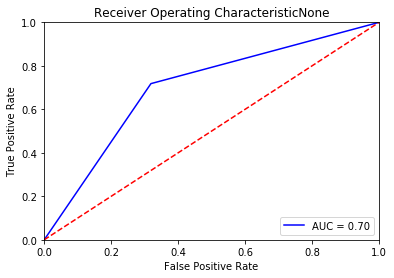

In [462]:
tec = None
plotModel(blender_specific, X_testss, y_testss)
#soft

In [463]:
blender_specific = blend_models(estimator_list = [top5[0], top5[1]], method = 'hard')

,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC
0,0.7939,0.0000,0.8049,0.8526,0.8281,0.5713,0.5728
1,0.7967,0.0000,0.8140,0.8499,0.8316,0.5755,0.5763
2,0.8090,0.0000,0.8192,0.8640,0.8410,0.6023,0.6037
3,0.8108,0.0000,0.8192,0.8666,0.8422,0.6063,0.6078
4,0.7981,0.0000,0.8066,0.8575,0.8313,0.5805,0.5822
5,0.8065,0.0000,0.8237,0.8570,0.8400,0.5956,0.5963
6,0.7871,0.0000,0.8042,0.8432,0.8233,0.5561,0.5570
7,0.7966,0.0000,0.8072,0.8550,0.8304,0.5770,0.5785
8,0.8037,0.0000,0.8123,0.8615,0.8362,0.5917,0.5933
9,0.8012,0.0000,0.8089,0.8604,0.8339,0.5870,0.5887


[[6006 2695]
 [ 341  809]]
0.7034782608695652


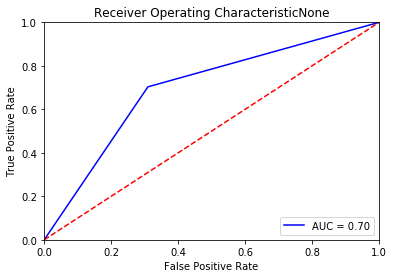

In [464]:
tec = None
plotModel(blender_specific, X_testss, y_testss)
#hard

### 7. Tuned model of top5

In [475]:
tuned5 = [tune_model(i) for i in top5]

,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC
0,0.7562,0.8502,0.8882,0.7580,0.8180,0.4560,0.4693
1,0.7671,0.8578,0.8078,0.8133,0.8105,0.5085,0.5086
2,0.7798,0.8686,0.8072,0.8309,0.8189,0.5383,0.5387
3,0.7826,0.8654,0.7975,0.8417,0.8190,0.5475,0.5487
4,0.7640,0.8524,0.7855,0.8236,0.8041,0.5077,0.5086
5,0.7710,0.8637,0.8163,0.8131,0.8147,0.5151,0.5151
6,0.7625,0.8577,0.7911,0.8177,0.8042,0.5026,0.5031
7,0.7702,0.8639,0.8009,0.8220,0.8113,0.5177,0.5180
8,0.7632,0.8564,0.7821,0.8249,0.8029,0.5068,0.5080
9,0.7804,0.8699,0.8083,0.8311,0.8195,0.5394,0.5397


In [476]:
tune_model(top5[1], optimize = ['Recall', 'AUC'])

SystemExit: (Value Error): Optimization method not supported. See docstring for list of available parameters.

[[6110 2591]
 [ 339  811]]
0.7052173913043478


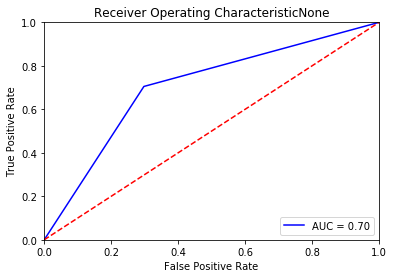

In [477]:
tec = None
plotModel(tuned5[0], X_testss, y_testss)

[[5861 2840]
 [ 328  822]]
0.7147826086956521


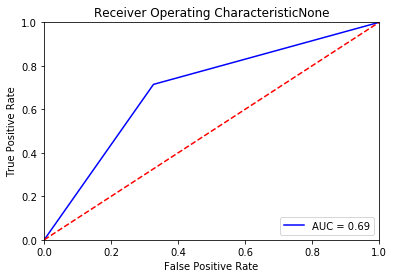

In [478]:
tec = None
plotModel(tuned5[1], X_testss, y_testss)

[[6131 2570]
 [ 349  801]]
0.6965217391304348


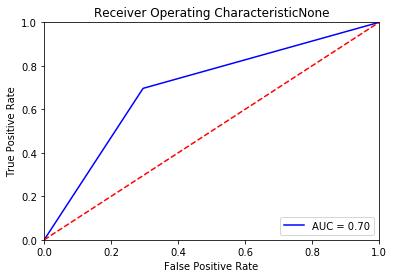

In [479]:
tec = None
plotModel(tuned5[2], X_testss, y_testss)

[[6128 2573]
 [ 348  802]]
0.697391304347826


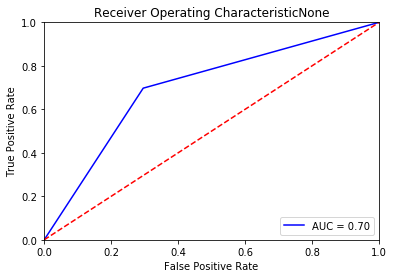

In [480]:
tec = None
plotModel(tuned5[3], X_testss, y_testss)

[[5600 3101]
 [ 329  821]]
0.7139130434782609


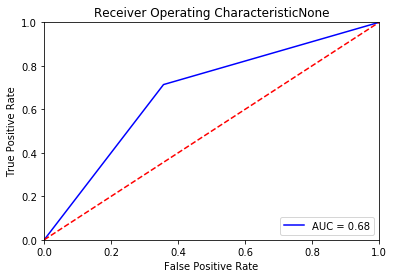

In [481]:
tec = None
plotModel(tuned5[4], X_testss, y_testss)